In [11]:
# Import All Required Packages
import os
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

In [12]:
# 2.Read Images from the data path
# データパスの設定
data_path = './jaffe/'

img_rows=256
img_cols=256
num_channel=1

# hyper parameters
num_epoch=10
batch_size=32
lr = 0.0001

img_data_list = []

# 画像ファイルの拡張子を指定
img_extensions = ['.tiff', '.jpg', '.png']

# ディレクトリ内のファイルを直接処理して画像を読み込み、リサイズしてリストに追加
for img_file in os.listdir(data_path):
    if any(img_file.endswith(ext) for ext in img_extensions):
        input_img = cv2.imread(os.path.join(data_path, img_file))
        if input_img is not None:
            input_img_resize = cv2.resize(input_img, (128, 128))
            img_data_list.append(input_img_resize)

img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
print(f"Total images loaded: {img_data.shape[0]}")
img_data.shape

FileNotFoundError: [Errno 2] No such file or directory: './jaffe/'

In [28]:
# 3.Define the number of classes
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

# Fixed label indexing - corrected the ranges to avoid gaps
labels[0:30]=0   # ANGRY (30 images)
labels[30:59]=1  # DISGUST (29 images) 
labels[59:92]=2  # FEAR (33 images) - fixed gap
labels[92:124]=3 # HAPPY (32 images) - fixed indexing
labels[124:155]=4 # NEUTRAL (31 images) - fixed indexing
labels[155:187]=5 # SAD (32 images) - fixed indexing
labels[187:]=6   # SURPRISE (remaining images)

names = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE']

def getLabel(id):
    return ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'][id]

# Print label distribution
unique, counts = np.unique(labels, return_counts=True)
for i, (label, count) in enumerate(zip(unique, counts)):
    print(f"{names[label]}: {count} images")

ANGRY: 30 images
DISGUST: 29 images
FEAR: 33 images
HAPPY: 32 images
NEUTRAL: 31 images
SAD: 32 images
SURPRISE: 26 images


In [30]:
class JAFFEDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = torch.FloatTensor(images)
        # Convert labels to LongTensor for CrossEntropyLoss (class indices, not one-hot)
        if len(labels.shape) > 1 and labels.shape[1] > 1:
            # If labels are one-hot encoded, convert to class indices
            self.labels = torch.argmax(labels, dim=1).long()
        else:
            # If labels are already class indices
            self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
     
        return image, label

In [32]:
# 4.Prepare the dataset - Use class indices instead of one-hot encoding for CrossEntropyLoss

# Shuffle the dataset
x, y = shuffle(img_data, labels, random_state=2)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=2)

# 画像データをPyTorchの形式に変換（チャンネルを先頭に）
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

# データセットの作成
train_dataset = JAFFEDataset(X_train, y_train)
test_dataset = JAFFEDataset(X_test, y_test)

# DataLoaderの作成
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(train_loader)
print(test_loader)

In [7]:
# 5.make CNN model - Fixed: removed softmax from forward pass
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Fixed calculation: 128/4 = 32
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)  # Fixed calculation
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [8]:
model = CNNModel(num_classes)
model

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
# see the summary of the model
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Linear-5                  [-1, 128]       8,388,736
           Dropout-6                  [-1, 128]               0
            Linear-7                    [-1, 7]             903
Total params: 8,409,031
Trainable params: 8,409,031
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 7.50
Params size (MB): 32.08
Estimated Total Size (MB): 39.77
----------------------------------------------------------------


In [16]:
# Test the model with a batch to verify shapes
images, labels = next(iter(train_loader))

# モデルを評価モードに設定
model.eval()

# 勾配計算を無効化
with torch.no_grad():
    # 順伝播
    outputs = model(images)
    
# 結果を表示
print("outputs:", outputs.shape)
print('labels:', labels.shape)
print('labels.shape == outputs.shape[0]:', labels.shape[0] == outputs.shape[0])
print('Sample outputs:', outputs[0])
print('Sample labels:', labels[:8])

# Test loss calculation
test_loss = criterion(outputs, labels)
print(f'Test loss: {test_loss.item():.4f}')
print('✓ Model and data shapes are compatible!')

outputs: torch.Size([32, 7])
labels: torch.Size([32])
labels.shape == outputs.shape[0]: True
Sample outputs: tensor([-0.0118, -0.1981, -0.0071,  0.1226, -0.0356,  0.0821, -0.1281])
Sample labels: tensor([2, 3, 4, 3, 3, 3, 6, 2])
Test loss: 1.9214
✓ Model and data shapes are compatible!


In [12]:
# モデル保存用のディレクトリを作成
os.makedirs('checkpoints', exist_ok=True)

# 学習の進捗を記録するためのCSVファイルを設定
csv_filename = 'model_train_new.csv'
with open(csv_filename, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy'])

# 最良のモデルを保存するための変数
best_val_loss = float('inf')
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

# Fixed training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    print(f'Using device: {device}')
    model = model.to(device)
    
    global best_val_loss
    
    for epoch in range(num_epochs):
        # 学習モード
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # 勾配をゼロにリセット
            optimizer.zero_grad()
            
            # 順伝播
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # 逆伝播と最適化
            loss.backward()
            optimizer.step()
            
            # 統計情報の更新
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # 検証モード
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # エポックごとの統計情報を計算
        train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        # リストに追加
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        
        # 結果をCSVに保存
        with open(csv_filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc])
        
        # 最良のモデルを保存
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'checkpoints/best_model.pth')
        
        # 進捗を表示
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)
    
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [13]:
# Start training
print("Starting training...")
train_losses, train_accs, val_losses, val_accs = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epoch
)
print("Training completed!")

Starting training...
Using device: cpu
Epoch [1/10]
Train Loss: 1.9615, Train Acc: 11.05%
Val Loss: 1.9910, Val Acc: 9.38%
--------------------------------------------------
Epoch [2/10]
Train Loss: 1.9498, Train Acc: 13.26%
Val Loss: 1.9502, Val Acc: 18.75%
--------------------------------------------------
Epoch [3/10]
Train Loss: 1.9431, Train Acc: 17.13%
Val Loss: 1.9578, Val Acc: 18.75%
--------------------------------------------------
Epoch [4/10]
Train Loss: 1.9408, Train Acc: 18.23%
Val Loss: 1.9691, Val Acc: 18.75%
--------------------------------------------------
Epoch [5/10]
Train Loss: 1.9307, Train Acc: 18.78%
Val Loss: 1.9524, Val Acc: 9.38%
--------------------------------------------------
Epoch [6/10]
Train Loss: 1.9164, Train Acc: 19.89%
Val Loss: 1.9587, Val Acc: 15.62%
--------------------------------------------------
Epoch [7/10]
Train Loss: 1.9288, Train Acc: 20.99%
Val Loss: 1.9571, Val Acc: 15.62%
--------------------------------------------------
Epoch [8/10

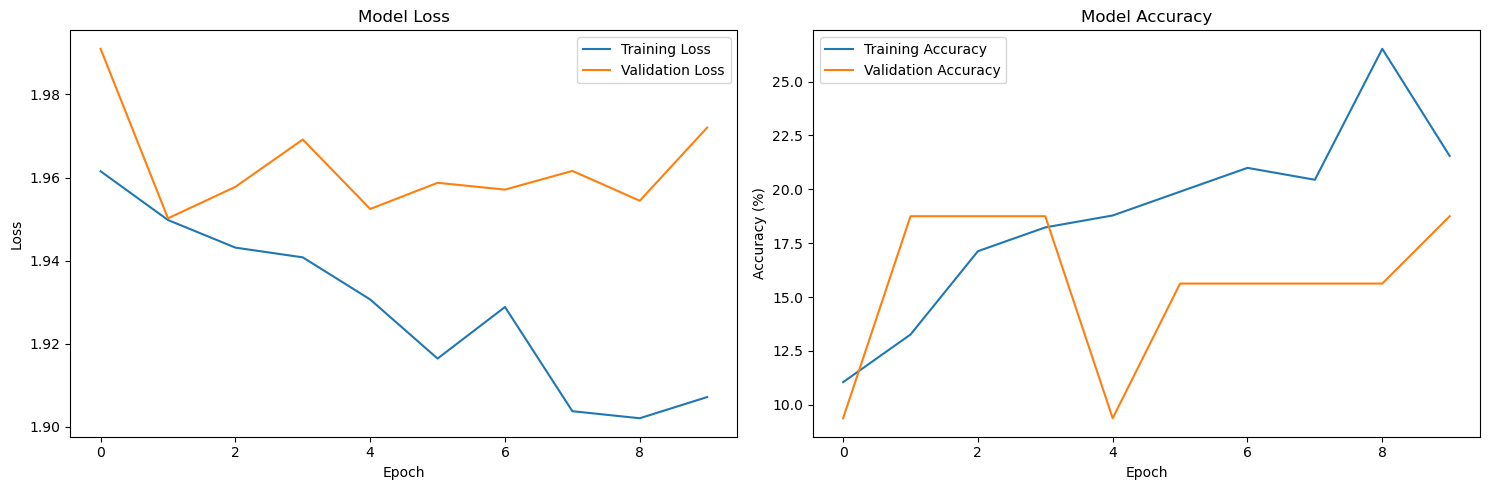

Best validation accuracy: 18.75%
Final training accuracy: 21.55%
Final validation accuracy: 18.75%


In [14]:
# Plot training results
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(val_accs):.2f}%")
print(f"Final training accuracy: {train_accs[-1]:.2f}%")
print(f"Final validation accuracy: {val_accs[-1]:.2f}%")

In [19]:
# Load best model and evaluate
model.load_state_dict(torch.load('checkpoints/best_model.pth'))
model.eval()

# Evaluate on test set
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)

all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(all_predictions)
print(all_labels)
print(names)

# Calculate accuracy
accuracy = np.mean(np.array(all_predictions) == np.array(all_labels)) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Print classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=names))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(names))
plt.xticks(tick_marks, names, rotation=45)
plt.yticks(tick_marks, names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


[3, 3, 5, 5, 5, 3, 5, 3, 5, 5, 3, 3, 3, 3, 5, 5, 3, 5, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 5, 3, 5]
[4, 0, 5, 5, 2, 3, 2, 4, 2, 2, 2, 1, 3, 2, 5, 1, 0, 4, 0, 1, 0, 2, 4, 2, 0, 0, 5, 2, 1, 1, 2, 3]
['ANGRY', 'DISGUST', 'FEAR', 'HAPPY', 'NEUTRAL', 'SAD', 'SURPRISE']


/var/folders/f0/7v890vfn2jq6v3q8ndhy5bth0000gn/T/ipykernel_6038/527063366.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints/b

'\n# Calculate accuracy\naccuracy = np.mean(np.array(all_predictions) == np.array(all_labels)) * 100\nprint(f"Test Accuracy: {accuracy:.2f}%")\n\n# Print classification report\nfrom sklearn.metrics import classification_report, confusion_matrix\nprint("\nClassification Report:")\nprint(classification_report(all_labels, all_predictions, target_names=names))\n\n# Plot confusion matrix\ncm = confusion_matrix(all_labels, all_predictions)\nplt.figure(figsize=(8, 6))\nplt.imshow(cm, interpolation=\'nearest\', cmap=plt.cm.Blues)\nplt.title(\'Confusion Matrix\')\nplt.colorbar()\ntick_marks = np.arange(len(names))\nplt.xticks(tick_marks, names, rotation=45)\nplt.yticks(tick_marks, names)\nplt.ylabel(\'True Label\')\nplt.xlabel(\'Predicted Label\')\nplt.tight_layout()\nplt.show()\n'